# Training

In [155]:
dataset_filepattern = 'data/*.bin'

_SQUARE_SIZE = 25
_CROP_SIZE = 24  # Divisible by 8.
_MARGIN = (_CROP_SIZE / 2) + 1
_BLUR = 1

In [156]:
# Read data.

import glob
import msgpack
import numpy as np

dataset = []
dataset_golden = []
filenames = glob.glob(dataset_filepattern)
for filename in filenames:
  unpacker = msgpack.Unpacker(open(filename, 'rb'))
  for img, gt in unpacker:
    blur = cv2.GaussianBlur(np.uint8(img), (_BLUR, _BLUR), 0)
    if filename.endswith('golden.bin'):
        dataset_golden.append((blur, np.int8(gt)))
    else:
        dataset.append((blur, np.int8(gt)))
print 'Loaded %d boards from %d files' % (len(dataset), len(filenames))
print 'Loaded %d golden boards from %d files' % (len(dataset_golden), len(filenames))

Loaded 167 boards from 5 files
Loaded 4 golden boards from 5 files


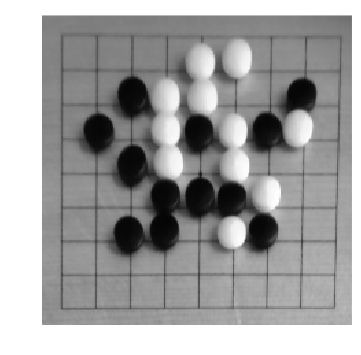

In [157]:
# Show the first board.

import matplotlib.pylab as plt
plt.imshow(dataset[0][0], cmap='gray', vmin=0, vmax=255, interpolation='none')
plt.axis('off')
plt.show()

In [167]:
# Crop relevant regions.

def CropLocalRegion(img, i, j, offset_x=0, offset_y=0): 
  x = _MARGIN + i * _SQUARE_SIZE - _CROP_SIZE / 2 + offset_x
  y = _MARGIN + j * _SQUARE_SIZE - _CROP_SIZE / 2 + offset_y
  if (x < 0 or x + _CROP_SIZE >= img.shape[1] or
      y < 0 or y + _CROP_SIZE >= img.shape[0]):
    return None
  return img[y:y + _CROP_SIZE, x:x + _CROP_SIZE]


def BuildImageData(ds, jitter=0):
    imgs = []
    lbls = []
    for img, gt in ds:
      for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
          for k in range(-jitter, jitter + 1, 1):
            for l in range(-jitter, jitter + 1, 1):
              crop = CropLocalRegion(img, i, j, k, l)
              if crop is not None:
                imgs.append(crop)
                lbls.append(gt[i][j])
    lbls = np.array(lbls)
    imgs = np.stack(imgs, axis=0)
    return imgs, lbls

images, labels = BuildImageData(dataset, jitter=1)
images_golden, labels_golden = BuildImageData(dataset_golden)
print 'Generated %d samples' % len(labels)
print 'Generated %d golden samples' % len(labels_golden)

Generated 219644 samples
Generated 1444 golden samples


There are 150353 samples for class 0.
There are 37851 samples for class 1.
There are 31440 samples for class 2.


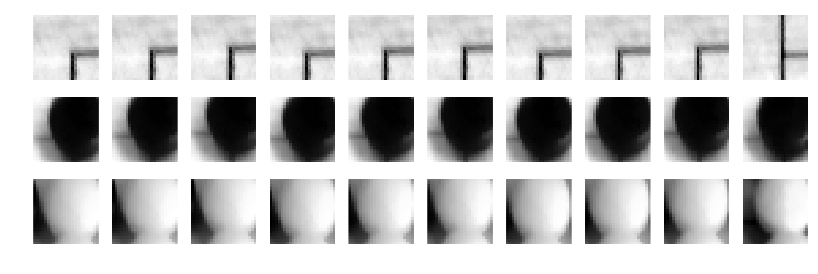

In [168]:
# Show a few samples for each class.

import matplotlib.pylab as plt

num_samples = 10

plt.figure(figsize=(num_samples, 3))
for label in (0, 1, 2):
  indices = (labels == label)
  print 'There are %d samples for class %d.' % (np.sum(indices), label)
  sample_images = images[indices][:num_samples]
  for i, img in enumerate(sample_images):
    plt.subplot(3, num_samples, label * num_samples + i + 1)
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.axis('off')
plt.show()

In [169]:
# Build features.

import cv2

def ComputeHoG(img):
  gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
  gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
  mag, ang = cv2.cartToPolar(gx, gy)
  bin_n = 16  # Number of orientation bins.
  bin = np.int32(bin_n * ang / (2 * np.pi))
  bin_cells = []
  mag_cells = []
  cellx = celly = 8
  for i in range(img.shape[0] / celly):
    for j in range(img.shape[1] / cellx):
      bin_cells.append(bin[i * celly:i * celly + celly, j * cellx:j * cellx + cellx])
      mag_cells.append(mag[i * celly:i * celly + celly, j * cellx:j * cellx + cellx])
  hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
  hist = np.hstack(hists)
  # Transform to Hellinger kernel.
  eps = 1e-7
  hist /= hist.sum() + eps
  hist = np.sqrt(hist)
  hist /= np.linalg.norm(hist) + eps
  return hist.astype(np.float32, copy=False)

def ComputeLBP(img):
  v = ((1<<7) * (img[0:-2,0:-2] >= img[1:-1,1:-1]) +
       (1<<6) * (img[0:-2,1:-1] >= img[1:-1,1:-1]) +
       (1<<5) * (img[0:-2,2:] >= img[1:-1,1:-1]) +
       (1<<4) * (img[1:-1,2:] >= img[1:-1,1:-1]) +
       (1<<3) * (img[2:,2:] >= img[1:-1,1:-1]) +
       (1<<2) * (img[2:,1:-1] >= img[1:-1,1:-1]) +
       (1<<1) * (img[2:,:-2] >= img[1:-1,1:-1]) +
       (1<<0) * (img[1:-1,:-2] >= img[1:-1,1:-1]))
  bin_n = 256
  hist = np.bincount(v.ravel(), minlength=bin_n)
  hist = hist.astype(np.float32, copy=False)
  eps = 1e-7
  hist /= hist.sum() + eps
  hist = np.sqrt(hist)
  hist /= np.linalg.norm(hist) + eps
  return hist
   

data = []
for img in images:
  data.append(ComputeHoG(img))
data = np.array(data)

data_golden = []
for img in images_golden:
  data_golden.append(ComputeHoG(img))
data_golden = np.array(data_golden)

print 'Generated data with shape:', data.shape
print 'Generated golden data with shape:', data_golden.shape

Generated data with shape: (219644, 144)
Generated golden data with shape: (1444, 144)


In [170]:
# Train empty vs. rest.

from sklearn import svm
from sklearn import model_selection

new_labels = labels.copy()
new_labels[new_labels != 0] = 1

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, new_labels, test_size=0.2, stratify=labels)

clf = svm.SVC(kernel='linear', class_weight='balanced')
clf.fit(X_train, y_train)
print 'Done'

Done


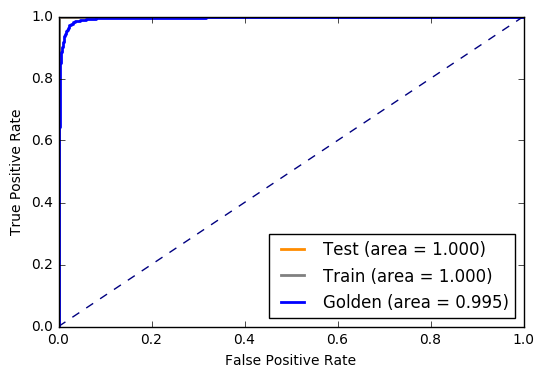

In [171]:
from sklearn import metrics

# Test.
fpr, tpr, _ = metrics.roc_curve(y_test, clf.decision_function(X_test))
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Test (area = %0.3f)' % auc)

# Train.
fpr, tpr, _ = metrics.roc_curve(y_train, clf.decision_function(X_train))
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='gray', lw=2, label='Train (area = %0.3f)' % auc)

# Golden.
new_labels = labels_golden.copy()
new_labels[new_labels != 0] = 1
fpr, tpr, _ = metrics.roc_curve(new_labels, clf.decision_function(data_golden))
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label='Golden (area = %0.3f)' % auc)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [163]:
# Happy? Save the model.

with open('models/empty_full.bin', 'wb') as fp:
  fp.write(msgpack.packb(np.squeeze(clf.coef_).tolist()))
  fp.write(msgpack.packb(clf.intercept_[0]))

In [172]:
# Train white vs. black.

new_data = data[labels != 0]
new_labels = labels[labels != 0] - 1  # 0 is Black, 1 is White.

# Split.
X_train, X_test, y_train, y_test = model_selection.train_test_split(new_data, new_labels, test_size=0.2, stratify=new_labels)

clf = svm.SVC(kernel='linear', class_weight='balanced')
clf.fit(X_train, y_train);
print 'Done'

Done


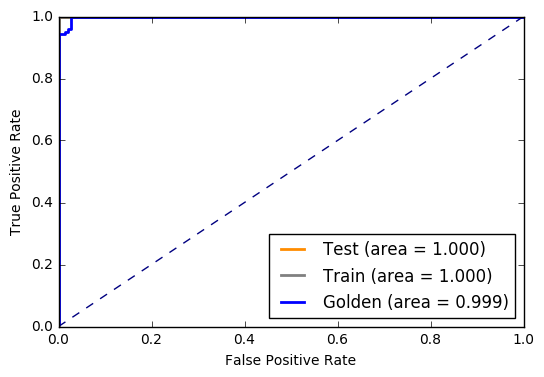

In [173]:
# Test.
fpr, tpr, _ = metrics.roc_curve(y_test, clf.decision_function(X_test))
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Test (area = %0.3f)' % auc)

# Train.
fpr, tpr, _ = metrics.roc_curve(y_train, clf.decision_function(X_train))
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='gray', lw=2, label='Train (area = %0.3f)' % auc)

# Golden.
new_data = data_golden[labels_golden != 0]
new_labels = labels_golden[labels_golden != 0] - 1  # 0 is Black, 1 is White.
fpr, tpr, _ = metrics.roc_curve(new_labels, clf.decision_function(new_data))
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label='Golden (area = %0.3f)' % auc)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [166]:
# Happy? Save the model.

with open('models/black_white.bin', 'wb') as fp:
  fp.write(msgpack.packb(np.squeeze(clf.coef_).tolist()))
  fp.write(msgpack.packb(clf.intercept_[0]))